## Author name:

<pre> Babak Ansari-Jaberi</pre>
<pre> SCS 3253 013 Machine Learning final project</pre>

# User Story points(weight) prediction

### Data Prepration

Load data from development tracking software and prepare it for machine learning.

The data would include the work item number, the previously predicted weight and columns of required activities (called labels) to be used for training.

In [92]:
# pip install jira
from jira import JIRA
import getpass
import pandas as pd
import numpy as np
import os.path
from pandas import ExcelWriter
from sklearn.metrics import precision_recall_curve
import matplotlib.pyplot as plt
from sklearn.utils.fixes import signature
from sklearn.metrics import roc_curve, auc
from sklearn.model_selection import cross_val_score
import seaborn as sns
from sklearn.multiclass import OneVsRestClassifier
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import label_binarize
from scipy import interp
from itertools import cycle
import warnings
import random
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import confusion_matrix
warnings.filterwarnings('ignore')


file_name = 'Team1JiraReportMain.xlsx'
sheetname = 'User Story Prediction'
ML_NA = 0
ML_S = 0.33
ML_M = 0.67
ML_L = 1
ML_Coef = 100
jiraFileExist = os.path.exists(file_name)

if not jiraFileExist:
    #input( "Username: ")
    userName = 'bob.ansari@intelex.com' 
    password = getpass.getpass(prompt='Username: '+userName+'\r\nPassword: ')


    auth_jira = JIRA(server = 'https://intelex.atlassian.net', auth=( userName, password ))

    # my top 5 issues due by the end of the week, ordered by priority
    oh_crap = auth_jira.search_issues('"Tech Team"="Team 1" AND Sprint is not EMPTY AND "Story Points" is not EMPTY and labels is not EMPTY order by priority desc', maxResults=3000)
    print("User "+userName+" is logged in")

In [93]:
# Read data source to create data frame of the labels
# Insert labels into data frame
if not jiraFileExist:
    print("Reading from Jira...")
    pd.options.mode.chained_assignment = None  # default='warn'
    labels_df = pd.DataFrame(columns=['Labels'])
    story_df = pd.DataFrame(columns=['Index', 'Key', 'Summary', 'Points', 'Labels'])
    
    i = 0
    r = 0
    for issue in oh_crap:
        hasMlTag = False
        for label in issue.fields.labels:
            if 'ML-' in label:
                labels_df.loc[i] = [label]
                hasMlTag = True
            i = i + 1
        if hasMlTag:
            story_df.loc[i] = [r, issue.key, issue.fields.summary, issue.fields.customfield_10049, None]
            story_df.at[i, 'Labels'] = issue.fields.labels
            r = r+1

    print("Number of records read: ",r)

########### With Weight #############
#     # Create labels data set
#     labels_df = labels_df.drop_duplicates()

#     # Labels without ML-X-
#     for index, row in labels_df.iterrows():
#         if 'ML-S-' in row['Labels'] or 'ML-M-' in row['Labels'] or 'ML-L-' in row['Labels']:
#             labels_df.loc[index, 'Labels'] = row['Labels'][5:]
    
#     labels_df = labels_df.drop_duplicates()
#     labels_df = labels_df.set_index('Labels').T.copy()    
    
    
#     #  combined labels table
#     combine_df = pd.concat([story_df, labels_df], ignore_index=False)
#     for index, row in combine_df.iterrows():
#         for label in labels_df.columns:
#             combine_df.loc[index, label] = 0 #np.random.normal(ML_NA, 0.01, 1)[0]*100
#         for label in row['Labels']:
#             if 'ML-' in label:
#                 col = label[5:]
#                 if 'ML-S-' in label:
#                     combine_df.loc[index, col] = ML_S*ML_Coef #np.random.normal(ML_S, 0.05, 1)[0]*100
#                 elif 'ML-M-' in label:
#                     combine_df.loc[index, col] = ML_M*ML_Coef #np.random.normal(ML_M, 0.10, 1)[0]*100
#                 elif 'ML-L-' in label:
#                     combine_df.loc[index, col] = ML_L*ML_Coef #np.random.normal(ML_L, 0.05, 1)[0]*100
#     df = combine_df.drop(columns=['Labels'])
#####################################
######### Without Weight ###########
    labels_df = labels_df.drop_duplicates()
    labels_df = labels_df.set_index('Labels').T
    
    combine_df = pd.concat([story_df, labels_df], ignore_index=False)
    
    for index, row in combine_df.iterrows():
        #print( row['Key'], row['Points'] )
        for label in row['Labels']:
            if label in labels_df.columns:
                combine_df.loc[index, label] = 1
    
    df = combine_df.drop(columns=['Labels'])
    df.fillna(ML_NA, inplace=True)
######################################
   
    writer = ExcelWriter(file_name)
    df.to_excel(writer,sheetname)
    writer.save()
else:
    print("Data loaded from file:",file_name)
    df = pd.read_excel(file_name, sheetname)


Data loaded from file: Team1JiraReportMain.xlsx


In [94]:
#df.describe()
df.head()

,Index,Key,ML-L-Code-Automation,ML-L-Code-Business,ML-L-Code-UI,ML-L-Studying,ML-L-Test-Automation,ML-L-Test-Manual,ML-M-Code-Automation,ML-M-Code-Business,...,ML-S-Code-Business,ML-S-Code-Script,ML-S-Code-UI,ML-S-Communication,ML-S-Configuration,ML-S-Studying,ML-S-Test-Automation,ML-S-Test-Manual,Points,Summary
8,0,ILX-13044,0,0,0,0,0,0,0,1,...,0,0,0,0,0,0,0,0,3,Logout from V6 or ACTS does not actually logou...
14,1,ILX-11815,0,0,0,0,0,0,0,1,...,0,0,0,0,0,0,0,0,3,Some of the Alliance admin users are not able ...
17,2,ILX-11017,0,0,0,0,0,0,0,0,...,1,0,0,1,0,0,0,1,2,DataCollector is not working for PROD sites
20,3,ILX-11877,0,0,0,0,0,0,0,1,...,0,0,0,0,0,0,0,0,3,Deleting an object inherited from abstract obj...
28,4,ILX-13509,0,0,0,0,0,0,0,0,...,0,0,1,0,0,0,0,1,2,"Login page, request password reset page, reset..."


In [95]:
def scatter_plot(ml):
    f, ax = plt.subplots(1, 2, sharey=False, figsize=(14,5))
    sns.regplot(x=df["Points"], y=df[ml], color='yellow', marker='.', ax=ax[0])
    cmap = sns.cubehelix_palette(dark=0.5, light=1, as_cmap=True)
    sns.scatterplot(x="Points", y=ml,
                         hue=ml, size=ml, alpha =0.5,
                         sizes=(20, 200), palette = cmap, ax=ax[0],
                         legend="full", data=df)
    #sns.distplot( df[df[ml]!=0][ml], ax=ax[1] )
    sns.distplot( df[ml], ax=ax[1] )
    plt.show()


# for label in labels_df.columns:
#     scatter_plot(label)

### Training 

Divide data into 60% for training and 40% for testing:

In [96]:
from sklearn.model_selection import train_test_split

train_set, test_set = train_test_split(df, test_size=0.40, random_state=42)
print(len(train_set), "train +", len(test_set), "test")

54 train + 36 test


Identify target column and feature variables:

In [97]:
target = 'Points'
features = list(train_set.columns)
features = [f for f in features if f!=target and f!='Index' and f!='Key' and f!='Summary']

# Split data into train and test sets
X_tr = train_set[features]
y_tr = train_set[[target]]

X_te = test_set[features]
y_te = test_set[[target]]

In [98]:
# Encode points using one hot encoder
from sklearn.preprocessing import OneHotEncoder

points_tr = train_set[[target]]

cat_encoder = OneHotEncoder(sparse=False)

points_tr_fit = cat_encoder.fit(points_tr)

points_tr_cat = points_tr_fit.transform(points_tr)

points_te = test_set[[target]]
points_te_cat = cat_encoder.fit_transform(points_te)

points_te_cat
y_tr = points_tr_cat
y_te = points_te_cat


Define training model liberaries and a function for finding best parameters for a model using for Grid Search:

In [99]:
import pandas

from sklearn import model_selection
from sklearn.linear_model import LogisticRegression
from sklearn.tree import DecisionTreeClassifier
from sklearn.svm import SVC
from sklearn.ensemble import RandomForestClassifier, AdaBoostClassifier, VotingClassifier
from sklearn.naive_bayes import GaussianNB
from sklearn.ensemble import ExtraTreesClassifier
from sklearn.model_selection import GridSearchCV
#from sklearn.cross_validation import KFold
from sklearn.neighbors import KNeighborsClassifier
from sklearn.svm import LinearSVC
from sklearn.neural_network import MLPClassifier
from nltk.classify.scikitlearn import SklearnClassifier

pd.options.mode.chained_assignment = None 

def SearchBestParameters(model, parameters):
    y = df[[target]]
    #yy = label_binarize(y, classes=[0, 1, 2 , 3, 4])
    yy = label_binarize(y, classes=[1, 2, 3 , 5, 8])
    n_classes = yy.shape[1]
    classifier = OneVsRestClassifier(model)

    #gs = GridSearchCV(classifier, parameters, cv=5, scoring='r2') # Using R^2 (coefficient of determination)
    gs = GridSearchCV(classifier, parameters, cv=5) # Using R^2 (coefficient of determination)
    gs.fit(X_tr, y_tr).decision_function(X_te)    
    
    #print(classifier.get_params().keys())
    model_params = {}
    for param in gs.best_params_:
        model_param = param.replace("estimator__", "")
        model_params[model_param] = gs.best_params_[param]
    print(type(model).__name__, ': ', model_params, 'with score:', gs.best_score_)
    return model_params

Using Grid Search to find the best parameters for `Logistic Regression` classifier:

In [100]:
grid = {
    'estimator__C': [0.1, 10, 100, 1000],
    'estimator__solver': ['newton-cg', 'lbfgs', 'sag', 'saga'],
    'estimator__multi_class': ['ovr', 'multinomial']
}
logistic = LogisticRegression()
best_params = SearchBestParameters(logistic, grid)
logistic = LogisticRegression(**best_params)   
    

LogisticRegression :  {'C': 100, 'multi_class': 'ovr', 'solver': 'newton-cg'} with score: 0.5740740740740741


Using Grid Search to find the best parameters for `SVC` classifier:

In [101]:
grid={
    'estimator__C': [ 0.1, 1, 10, 100, 100],
    #'estimator__gamma': [ 0.1,1, 10],
    'estimator__kernel': [ 'linear', 'poly', 'rbf']
}
svc = SVC(probability=True)
best_params = SearchBestParameters(svc, grid)
svc = SVC(probability=True, **best_params)

SVC :  {'C': 100, 'kernel': 'rbf'} with score: 0.5370370370370371


In [102]:
grid={
    'estimator__C': [0.1, 5, 10, 15],
    'estimator__multi_class': ['ovr', 'crammer_singer'], 
}
linearSVC = LinearSVC()
best_params = SearchBestParameters(linearSVC, grid)
linearSVC = LinearSVC(**best_params)

LinearSVC :  {'C': 5, 'multi_class': 'ovr'} with score: 0.5370370370370371


Add all models to ensemble and one of good one to Ada Boost classifier:

Create `score_model` function to draw the classifiers performance:

In [103]:
def one_hot_decode(coded):
    decoded = coded.dot(cat_encoder.active_features_).astype(int)
    
    try:
        decoded[:] = [1 if x==0 else 8 if x>8 else x for x in decoded]
    except TypeError:
        return 1 if decoded==0 else 8 if decoded>8 else decoded
    return decoded

def display_scores(scores):
    print("\033[1mCross Validation Score:\033[0m \n\t{} (+/- {})".format(round(scores.mean(),2), round(scores.std(),2)))

#one_hot_decode(np.array([[0,1,1,1,1], [0,1,1,0,0], [0,0,0,0,0], [1,1,1,1,1]]))


In [104]:
def create_fibonacci_numbers(size):
    fibonacci_numbers = [1, 1]
    for i in range(2,size):
        fibonacci_numbers.append((fibonacci_numbers[i-1]+fibonacci_numbers[i-2]))

    #fibonacci_numbers[0] = 0
    fibonacci_numbers = np.delete(fibonacci_numbers, 0)

    np.array(map(str, fibonacci_numbers))
    fibonacci_numbers = np.array(fibonacci_numbers)
    return fibonacci_numbers

create_fibonacci_numbers(8)

array([ 1,  2,  3,  5,  8, 13, 21])

In [105]:
def F(n):
    if n == 0: return 0
    elif n == 1: return 1
    else: return F(n-1)+F(n-2)
    
def score_model(model): 
    print('<< \033[1m', type(model).__name__, '\033[0m>>')
    # Binarize the output
    y = df[[target]]
    #classes=[0, 1, 2 , 3, 4]
    classes=[1, 2, 3 , 5, 8]
    yy = label_binarize(y, classes=classes)
    n_classes = yy.shape[1]

    classifier = OneVsRestClassifier(model)
    
    y_score = classifier.fit(X_tr, y_tr).decision_function(X_te) 
    # plot the roc curve
    if hasattr(model, 'predict_proba'):
        # Binarize the output
        lw=2
        fpr = dict()
        tpr = dict()
        roc_auc = dict()
        for i in range(n_classes):
            fpr[i], tpr[i], _ = roc_curve(y_te[:, i], y_score[:, i], pos_label=1)
            roc_auc[i] = auc(fpr[i], tpr[i])

        # Compute macro-average ROC curve and ROC area
        # First aggregate all false positive rates
        all_fpr = np.unique(np.concatenate([fpr[i] for i in range(n_classes)]))

        # Then interpolate all ROC curves at this points
        mean_tpr = np.zeros_like(all_fpr)
        for i in range(n_classes):
            mean_tpr += interp(all_fpr, fpr[i], tpr[i])

        # Compute micro-average ROC curve and ROC area
        fpr["micro"], tpr["micro"], _ = roc_curve(y_te.ravel(), y_score.ravel(), pos_label=1)
        roc_auc["micro"] = auc(fpr["micro"], tpr["micro"])

        # Finally average it and compute AUC
        mean_tpr /= n_classes

        fpr["macro"] = all_fpr
        tpr["macro"] = mean_tpr
        roc_auc["macro"] = auc(fpr["macro"], tpr["macro"])

        # Plot all ROC curves
        plt.figure(figsize=(8, 6))
        plt.plot(fpr["micro"], tpr["micro"],
                 label='micro-average ROC curve (area = {0:0.2f})'
                       ''.format(roc_auc["micro"]),
                 color='deeppink', linestyle=':', linewidth=4)

        plt.plot(fpr["macro"], tpr["macro"],
                 label='macro-average ROC curve (area = {0:0.2f})'
                       ''.format(roc_auc["macro"]),
                 color='navy', linestyle=':', linewidth=4)

        colors = cycle(['aqua', 'darkorange', 'cornflowerblue', 'blue', 'red', 'green'])
        for i, color in zip(range(n_classes), colors):
            plt.plot(fpr[i], tpr[i], color=color, lw=lw,
                     label='ROC curve of class {0} (area = {1:0.2f})'
                     ''.format(F(i+2), roc_auc[i]))

        plt.plot([0, 1], [0, 1], 'k--', lw=lw)
        plt.xlim([0.0, 1.0])
        plt.ylim([0.0, 1.05])
        plt.xlabel('False Positive Rate')
        plt.ylabel('True Positive Rate')
        plt.legend(loc="lower right")
        plt.grid()
        plt.xticks(np.arange(0,1.1,0.1))
        plt.yticks(np.arange(0,1.1,0.1))
        plt.show()

    # Test vs prediction scatter plot
    y_score_c = classifier.predict(X_te)

    decoded_y_te = one_hot_decode(y_te)
    decoded_y_score_c = one_hot_decode(y_score_c)
    
    #print(decoded_y_te.shape)
    #print(decoded_y_score_c.shape)
    
    cm = confusion_matrix(decoded_y_te, decoded_y_score_c)
        
    df_cm = pd.DataFrame(cm)
    xy_lbl = create_fibonacci_numbers(cm.shape[0]+1)    
    df_cm.columns = xy_lbl
    df_cm = df_cm.set_index(xy_lbl)
    
    plt.figure(figsize = (7,5))
    sns.heatmap(df_cm, annot=True)
    plt.show()

    # Test and prediction distribution plot
    sns.distplot( decoded_y_te )
    sns.distplot( decoded_y_score_c )
    plt.show()
        
    # Prediction Score
    print('\033[1mEstimator Score:\033[0m\n\tTraining: ', round(classifier.score(X_tr, y_tr), 2), 
            '\n\tTest : ', round(classifier.score(X_te, y_te),2))

    scores = cross_val_score(classifier, X_tr, y_tr,scoring="accuracy", cv=5)

    display_scores(scores)
    print('_______________________________________________________________________')
    return df_cm

In [106]:
# create the sub models

#logistic = LogisticRegression(C=0.001, solver='newton-cg',multi_class='multinomial')
#svc = SVC(C=10, gamma=0.01, kernel='poly', probability=True) 
#svc = SVC(C=100,kernel='rbf', probability=True) 
#svc = SVC(kernel='rbf', probability=True) 
#linearSVC = LinearSVC(C=2, multi_class='crammer_singer', tol= 1000.0)

#randomForest = RandomForestClassifier(criterion='entropy', max_depth=7, max_features='auto', n_estimators=10)

adaBoost = AdaBoostClassifier(logistic)  
#adaBoost = AdaBoostClassifier(linearSVC,algorithm='SAMME')  
#adaBoost = AdaBoostClassifier(svc,algorithm='SAMME', learning_rate=5, n_estimators=100)


Using `score_model` to plot the models accuracy:

<<  LogisticRegression >>


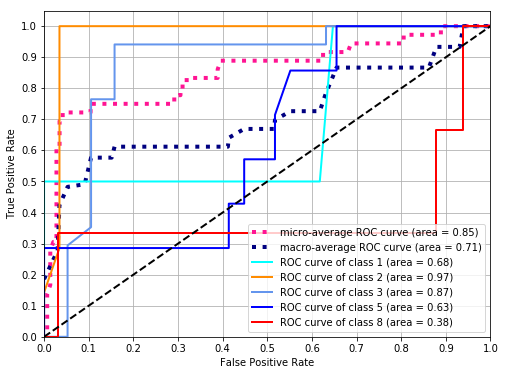

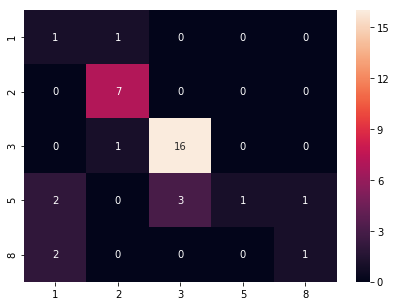

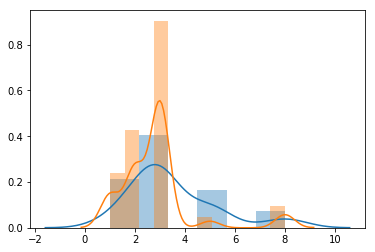

Estimator Score:
	Training:  0.96 
	Test :  0.69
Cross Validation Score: 
	0.57 (+/- 0.2)
_______________________________________________________________________
<<  SVC >>


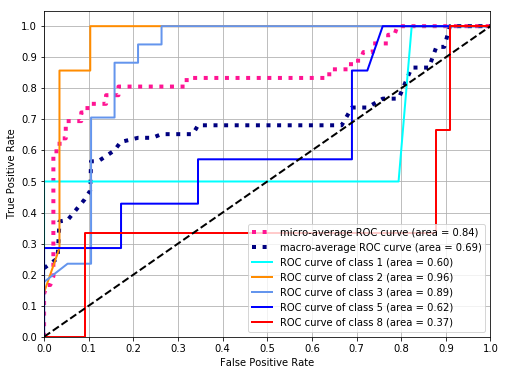

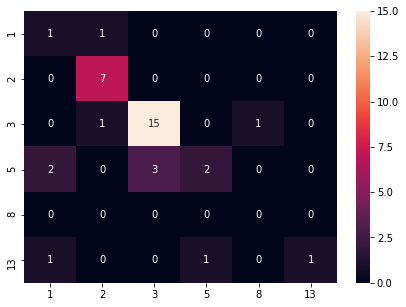

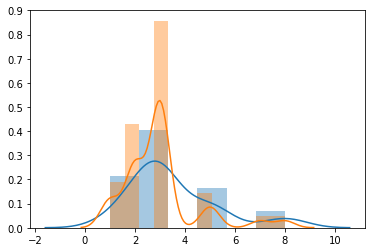

Estimator Score:
	Training:  0.98 
	Test :  0.69
Cross Validation Score: 
	0.53 (+/- 0.17)
_______________________________________________________________________
<<  AdaBoostClassifier >>


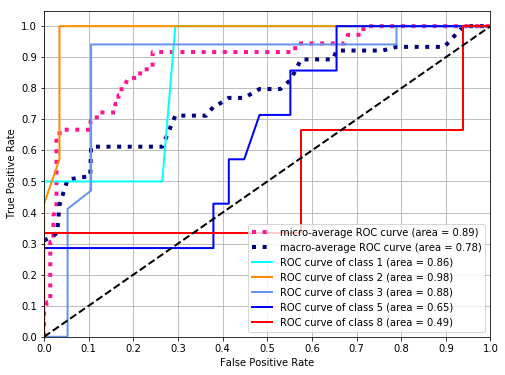

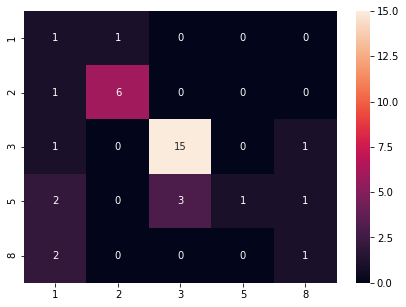

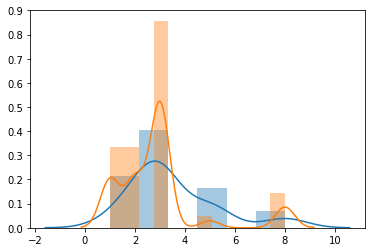

Estimator Score:
	Training:  0.94 
	Test :  0.61
Cross Validation Score: 
	0.49 (+/- 0.23)
_______________________________________________________________________
<<  LinearSVC >>


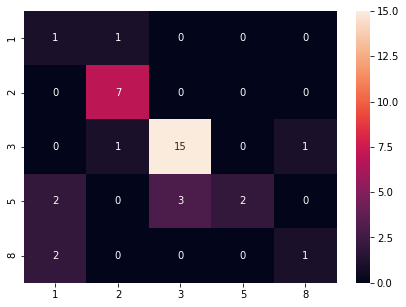

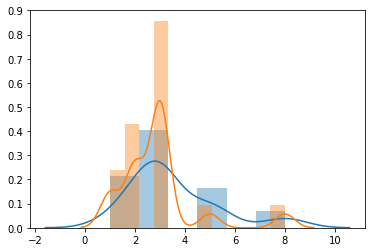

Estimator Score:
	Training:  0.96 
	Test :  0.69
Cross Validation Score: 
	0.53 (+/- 0.21)
_______________________________________________________________________


,1,2,3,5,8
1,1,1,0,0,0
2,0,7,0,0,0
3,0,1,15,0,1
5,2,0,3,2,0
8,2,0,0,0,1


In [107]:
score_model(logistic)
score_model(svc)
score_model(adaBoost)
score_model(linearSVC)


### Prediction

Get the User Story number and predict its size base on the given `Labels`:

In [123]:
prediction_df = df.copy()
prediction_df = prediction_df.drop(columns=['Index', 'Key', 'Points', 'Summary']).iloc[0:0]
prediction_df
df.head()


,Index,Key,ML-L-Code-Automation,ML-L-Code-Business,ML-L-Code-UI,ML-L-Studying,ML-L-Test-Automation,ML-L-Test-Manual,ML-M-Code-Automation,ML-M-Code-Business,...,ML-S-Code-Business,ML-S-Code-Script,ML-S-Code-UI,ML-S-Communication,ML-S-Configuration,ML-S-Studying,ML-S-Test-Automation,ML-S-Test-Manual,Points,Summary
8,0,ILX-13044,0,0,0,0,0,0,0,1,...,0,0,0,0,0,0,0,0,3,Logout from V6 or ACTS does not actually logou...
14,1,ILX-11815,0,0,0,0,0,0,0,1,...,0,0,0,0,0,0,0,0,3,Some of the Alliance admin users are not able ...
17,2,ILX-11017,0,0,0,0,0,0,0,0,...,1,0,0,1,0,0,0,1,2,DataCollector is not working for PROD sites
20,3,ILX-11877,0,0,0,0,0,0,0,1,...,0,0,0,0,0,0,0,0,3,Deleting an object inherited from abstract obj...
28,4,ILX-13509,0,0,0,0,0,0,0,0,...,0,0,1,0,0,0,0,1,2,"Login page, request password reset page, reset..."


In [109]:
def check_auth_jira_defined():
    try:
        return not auth_jira is None
    except:
        return True

In [116]:
userName = 'bob.ansari@intelex.com' 
#if not check_auth_jira_defined():
if True:
    password = getpass.getpass(prompt='Username: '+userName+'\r\nPassword: ')
    if not password:
        raise ValueError('Please provide password.')
    auth_jira = JIRA(server = 'https://intelex.atlassian.net', auth=( userName, password ))
    print('User '+userName+' is authenticated!')

Username: bob.ansari@intelex.com
Password: ········
User bob.ansari@intelex.com is authenticated!


Prepare the input data for prediction:

In [117]:
story = input( "User Story # ILX-")
#story = '8397' 3pts
#story = '10559' 2pts
#story = '9885' 8pts

issue = auth_jira.issue('ILX-'+story)
print('Predicting points for \033[1m\033[94m`',issue.fields.summary ,'`\033[0m User Story.')
print('Labels are: ' + str(issue.fields.labels))

User Story # ILX-12181
Predicting points for ` [TECH CHORE] - Improving Content Repo for Automation, Service and CI Build ` User Story.
Labels are: ['ML-L-Code-Automation', 'ML-M-Configuration', 'ML-M-Studying', 'ML-M-Test-Automation', 'build-investigation']


In [126]:
# for column in prediction_df.columns:
#     prediction_df.loc[0, column] = 0
#     for label in issue.fields.labels:
#         #prediction_df.loc[0, label] = 1
#         col = label[5:]
#         if 'ML-S-' in label:
#             prediction_df.loc[0, col] = ML_S*ML_Coef
#         elif 'ML-M-' in label:
#             prediction_df.loc[0, col] = ML_M*ML_Coef
#         else:
#             prediction_df.loc[0, col] = ML_L*ML_Coef

# print('Manual prediction was:\033[1m\033[94m', issue.fields.customfield_10049,'\033[0m')
for column in prediction_df.columns:
    prediction_df.loc[0, column] = 0
    for label in issue.fields.labels:
        if 'ML-' in label:
            #print(label)
            prediction_df.loc[0, label] = 1

print('Manual prediction was:\033[1m\033[94m', issue.fields.customfield_10049,'\033[0m')
prediction_df

ML-L-Code-Automation
ML-M-Configuration
ML-M-Studying
ML-M-Test-Automation
ML-L-Code-Automation
ML-M-Configuration
ML-M-Studying
ML-M-Test-Automation
ML-L-Code-Automation
ML-M-Configuration
ML-M-Studying
ML-M-Test-Automation
ML-L-Code-Automation
ML-M-Configuration
ML-M-Studying
ML-M-Test-Automation
ML-L-Code-Automation
ML-M-Configuration
ML-M-Studying
ML-M-Test-Automation
ML-L-Code-Automation
ML-M-Configuration
ML-M-Studying
ML-M-Test-Automation
ML-L-Code-Automation
ML-M-Configuration
ML-M-Studying
ML-M-Test-Automation
ML-L-Code-Automation
ML-M-Configuration
ML-M-Studying
ML-M-Test-Automation
ML-L-Code-Automation
ML-M-Configuration
ML-M-Studying
ML-M-Test-Automation
ML-L-Code-Automation
ML-M-Configuration
ML-M-Studying
ML-M-Test-Automation
ML-L-Code-Automation
ML-M-Configuration
ML-M-Studying
ML-M-Test-Automation
ML-L-Code-Automation
ML-M-Configuration
ML-M-Studying
ML-M-Test-Automation
ML-L-Code-Automation
ML-M-Configuration
ML-M-Studying
ML-M-Test-Automation
ML-L-Code-Automation
ML-M

,ML-L-Code-Automation,ML-L-Code-Business,ML-L-Code-UI,ML-L-Studying,ML-L-Test-Automation,ML-L-Test-Manual,ML-M-Code-Automation,ML-M-Code-Business,ML-M-Code-Script,ML-M-Code-UI,...,ML-S-Code-Automation,ML-S-Code-Business,ML-S-Code-Script,ML-S-Code-UI,ML-S-Communication,ML-S-Configuration,ML-S-Studying,ML-S-Test-Automation,ML-S-Test-Manual,build-investigation
0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


Create predict points function to use various models for prediction:

In [119]:
import operator

def predict_points(model, input_df): 
    classifier = OneVsRestClassifier(model)
    classifier.fit(X_tr, y_tr)
    predict = classifier.predict(prediction_df)
    if hasattr(model, 'predict_proba'):
        predict_prop = classifier.predict_proba(prediction_df)
        prediction = one_hot_decode(predict[0])
        index, value = max(enumerate(predict_prop[0]), key=operator.itemgetter(1))
        print('\033[1m',type(model).__name__, '\033[0mprediction is\033[1m\033[94m', 
            F(index+2), '\033[0mpoints with\033[1m\033[94m', round(value,2)*100,'%\033[0m probability')
    else:
        prediction = one_hot_decode(predict[0])
        print('\033[1m',type(model).__name__, '\033[0mprediction is\033[1m\033[94m', 
            prediction, '\033[0mpoints')
     

Predict using various prediction models:

In [121]:
prediction_df

,ML-L-Code-Automation,ML-L-Code-Business,ML-L-Code-UI,ML-L-Studying,ML-L-Test-Automation,ML-L-Test-Manual,ML-M-Code-Automation,ML-M-Code-Business,ML-M-Code-Script,ML-M-Code-UI,...,ML-S-Code-Automation,ML-S-Code-Business,ML-S-Code-Script,ML-S-Code-UI,ML-S-Communication,ML-S-Configuration,ML-S-Studying,ML-S-Test-Automation,ML-S-Test-Manual,build-investigation
0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0


In [120]:
predict_points(logistic, prediction_df)
predict_points(svc, prediction_df)
predict_points(linearSVC, prediction_df)
predict_points(adaBoost, prediction_df)


ValueError: X has 25 features per sample; expecting 24

### Conclusion

 - VotingClassifier, GaussianNB and SVC seems to perform very well
 - The data is not well defined and dimension could be reduced
 - There could be weightage for each Label to make prediction more accurate
 - Not enough data defined